In [1]:
import os
import cv2
import tqdm
import torch
import rawpy
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from scipy.optimize import least_squares


def load_image(data_path, image_name):
    image_file = data_path / 'Raw' / image_name
    depth_file = data_path / 'depthMaps' / f'depth{os.path.splitext(image_name)[0]}.tif'
    depth = np.array(Image.open(depth_file), dtype=np.float64)
    raw = rawpy.imread(str(image_file))
    rgb = raw.postprocess()
    rgb = cv2.resize(rgb / 255, depth.shape[::-1])
    return rgb, depth


def plot_image(image, **kwargs):
    plt.figure(figsize=(20, 20))
    plt.imshow(image, **kwargs)


def save_image(image, image_name):
    im = image - image.min()
    im = im / im.max()
    im = im * 255
    Image.fromarray(im.astype(np.uint8)).save(image_name)


def stretch_histogram(image, clip_percentile=0.0):
    im = image.copy()
    for channel in range(3):
        im[:, :, channel] = im[:, :, channel].clip(
            np.percentile(im[:, :, channel], clip_percentile),
            np.percentile(im[:, :, channel], 100 - clip_percentile)
        )
        im[:, :, channel] = (im[:, :, channel] - im[:, :, channel].mean()) / im[:, :, channel].std()
        im[:, :, channel] -= im[:, :, channel].min()
        im[:, :, channel] /= im[:, :, channel].max()
    return im


def compute_omega(I, depth, min_depth_percentile=1, max_depth_percentile=99):
    
    depth_ranges = np.linspace(
        np.percentile(depth, min_depth_percentile),
        np.percentile(depth, max_depth_percentile),
        11
    )
    
    omega = []
    for min_depth, max_depth in zip(depth_ranges[:-1], depth_ranges[1:]):
        args_depth_in_range = np.argwhere((depth >= min_depth) & (depth < max_depth))
        I_in_range = I[args_depth_in_range[:, 0], args_depth_in_range[:, 1]]
        mean_I_in_range = I_in_range.mean(axis=1)
        omega_range_mask = mean_I_in_range < np.percentile(mean_I_in_range, 1)
        omega.append(args_depth_in_range[omega_range_mask])
    return np.vstack(omega)


def compute_backscatter(I, depth, z):
    
    print('Computing backscatter')
    
    omega = compute_omega(I, depth)
    
    B_hat = I[omega[:, 0], omega[:, 1]]
    z = z[omega[:, 0], omega[:, 1]]
    
    B_inf_init = B_hat.mean(axis=0).tolist()
    beta_B_init = [2.5, 2.5, 2.5]
    J_prime_init = [0.0, 0.0, 0.0]
    beta_D_prime_init = [0.0, 0.0, 0.0]
    
    def residuals(x):
        B_inf, beta_B, J_prime, beta_D_prime = np.array_split(x, 4)
        return (B_hat - B_inf * (1 - np.exp(-beta_B * z)) - J_prime * np.exp(-beta_D_prime * z)).flatten()
    
    return least_squares(
        residuals,
        B_inf_init + beta_B_init + J_prime_init + beta_D_prime_init,
        bounds=([0] * 12, [1, 1, 1, 5, 5, 5] * 2),
        jac='3-point',
        verbose=2
    ).x


def LSAC(D, depth, sigma=0.1, eps=0.01, f=2):
    
    print('Computing LSAC')
    
    D = torch.tensor(D).cuda()
    
    Ne = np.zeros(depth.shape)
    Ne_vertical_mask = np.abs(depth[1:] - depth[:-1]) < eps
    Ne_horizontal_mask = np.abs(depth[:, 1:] - depth[:, :-1]) < eps
    Ne[1:] += Ne_vertical_mask
    Ne[:-1] += Ne_vertical_mask
    Ne[:, 1:] += Ne_horizontal_mask
    Ne[:, :-1] += Ne_horizontal_mask
    Ne = Ne.clip(min=1e-16)
    Ne = torch.tensor(Ne[..., np.newaxis]).double().cuda()
    Ne_vertical_mask = torch.tensor(Ne_vertical_mask[..., np.newaxis]).double().cuda()
    Ne_horizontal_mask = torch.tensor(Ne_horizontal_mask[..., np.newaxis]).double().cuda()
    
    a = torch.zeros(D.shape, dtype=torch.float64).cuda()
    
    p = torch.tensor(1 / (np.square(sigma * max(depth.shape)) + 1), dtype=torch.float64).cuda()
    
    for i in tqdm.tqdm(range(1000)):
        
        a_prime = torch.zeros(a.shape, dtype=torch.float64).cuda()
        a_prime[1:] += a[:-1] * Ne_vertical_mask
        a_prime[:-1] += a[1:] * Ne_vertical_mask
        a_prime[:, 1:] += a[:, :-1] * Ne_horizontal_mask
        a_prime[:, :-1] += a[:, 1:] * Ne_horizontal_mask
        a_prime /= Ne
        a = D * p + a_prime * (1 - p)
        
        if i % 10000 == 0:
            save_image(a.cpu().numpy(), f'lsac/{i:06d}.png')
    
    E_hat = f * a
    
    return E_hat.cpu().numpy()


def beta_D(a, b, c, d, z):
    return a * torch.exp(b * z) + c * torch.exp(d * z)


def init_beta_D_from_beta_D_prime(beta_D_prime, z):
    
    print('Initialize beta_D coefficients from beta_D_prime')
    
    beta_D_prime = torch.tensor(beta_D_prime).cuda()
    z = torch.tensor(z).cuda()
    
    def residuals(x):
        a, b, c, d = torch.tensor(x).cuda().tensor_split(4)
        return (beta_D_prime - beta_D(a, b, c, d, z)).flatten().cpu().numpy()

    return least_squares(
        residuals,
        [0] * 12,
        bounds=([0, -np.inf] * 6, [np.inf, 0] * 6),
        jac='3-point',
        verbose=2
    ).x


def compute_beta_D(D, depth, z, beta_D_prime):
    
    E_hat = LSAC(D, depth)
    
    beta_D_init = init_beta_D_from_beta_D_prime(beta_D_prime, z)
    
    E_hat = torch.tensor(E_hat).cuda()
    z = torch.tensor(z).cuda()
    
    print('Estimate beta_D coefficients')
    
    def residuals(x):
        a, b, c, d = torch.tensor(x).cuda().tensor_split(4)
        return (z + torch.log(E_hat) / beta_D(a, b, c, d, z)).flatten().cpu().numpy()
    
    return least_squares(
        residuals,
        beta_D_init,
        bounds=([0, -np.inf] * 6, [np.inf, 0] * 6),
        jac='3-point',
        verbose=2
    ).x

In [2]:
I, depth = load_image(Path('dataset/D1P1/'), 'T_S03136.ARW')
z = depth[..., np.newaxis].repeat(3, 2)

B_inf, beta_B, J_prime, beta_D_prime = np.array_split(compute_backscatter(I, depth, z), 4)

B = B_inf * (1 - np.exp(-beta_B * z))
D = I - B
D = D - D.min()

a, b, c, d = np.array_split(compute_beta_D(D, depth, z, beta_D_prime), 4)

save_image(stretch_histogram(D, 0), 'test/D.png')
save_image(D, 'test/RawD.png')
save_image(stretch_histogram(I, 0), 'test/I.png')
save_image(I, 'test/RawI.png')

Computing backscatter
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.7214e+02                                    1.30e+03    
       1              3         2.5598e+02      1.62e+01       1.28e-02       4.09e+01    
       2              4         2.4876e+02      7.22e+00       3.43e-01       6.40e+01    
       3              5         2.4825e+02      5.06e-01       1.06e-02       5.62e+01    
       4              6         2.3241e+02      1.58e+01       6.74e-01       3.14e+02    
       5              7         2.3165e+02      7.59e-01       2.91e-03       4.43e+01    
       6              9         2.2399e+02      7.66e+00       2.60e-01       8.15e+01    
       7             10         2.2372e+02      2.66e-01       4.30e-03       7.27e+01    
       8             11         2.1043e+02      1.33e+01       4.96e-01       4.41e+02    
       9             13         2.0840e+02      2.02e+00       4.96e

100%|██████████| 1000/1000 [01:00<00:00, 16.46it/s]


Initialize beta_D coefficients from beta_D_prime
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2404e+07                                    1.62e+07    
       1              2         1.2403e+07      6.48e+02       2.83e-05       1.62e+07    
       2              3         1.2402e+07      1.30e+03       5.66e-05       1.62e+07    
       3              4         1.2399e+07      2.59e+03       1.13e-04       1.62e+07    
       4              5         1.2394e+07      5.18e+03       2.26e-04       1.62e+07    
       5              6         1.2384e+07      1.04e+04       4.53e-04       1.62e+07    
       6              7         1.2363e+07      2.07e+04       9.05e-04       1.62e+07    
       7              8         1.2322e+07      4.14e+04       1.81e-03       1.61e+07    
       8              9         1.2239e+07      8.25e+04       3.62e-03       1.61e+07    
       9             10         1.2075e+0

In [3]:
J = D * np.exp((a * np.exp(b * z) + c * np.exp(d * z)) * z)

In [4]:
save_image(stretch_histogram(J, 0), 'test/J.png')
save_image(J, 'test/RawJ.png')

/home/clementin/anaconda3/envs/seathru/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


In [5]:
J.min()

0.0

In [11]:
J[:,:,1].min()

0.0

In [25]:
np.exp((a[1] * np.exp(b[1] * z[:, :, 1]) + c[1] * np.exp(d[1] * z[:, :, 1])) * z[:, :, 1])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [27]:
a[1] * np.exp(b[1] * z[:, :, 1]) + c[1] * np.exp(d[1] * z[:, :, 1])

array([[-3.50521316e+22, -3.48689371e+22, -3.46868778e+22, ...,
        -5.06344779e+16, -5.07442845e+16, -5.08543291e+16],
       [-3.53403244e+22, -3.51559842e+22, -3.49722469e+22, ...,
        -5.08382959e+16, -5.09485444e+16, -5.10591629e+16],
       [-3.56310694e+22, -3.54450309e+22, -3.52597829e+22, ...,
        -5.10429343e+16, -5.11537578e+16, -5.12646904e+16],
       ...,
       [-2.87816716e+31, -2.82858740e+31, -2.78945629e+31, ...,
        -4.49519145e+16, -4.47879972e+16, -4.46249066e+16],
       [-2.82760138e+31, -2.79353540e+31, -2.77662816e+31, ...,
        -4.47901789e+16, -4.46268514e+16, -4.44642335e+16],
       [-2.79763483e+31, -2.78068852e+31, -2.76385902e+31, ...,
        -4.46289108e+16, -4.44663994e+16, -4.43042526e+16]])

In [13]:
b

array([ -5.82217624,  43.01049489, -15.05133899])

In [14]:
c

array([ 8.87509113, -2.63189396, 10.19396058])

In [15]:
d

array([-0.49742838,  1.17939979, -0.72181494])

/home/clementin/anaconda3/envs/seathru/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


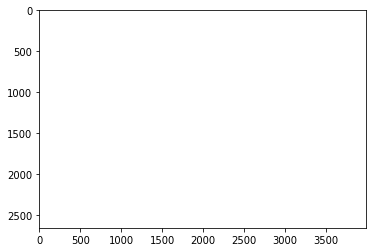

In [21]:
plt.imshow(J[:, :, 1] / J[:, :, 1].max())